In [ ]:
import pandas as pd
datafile = "winemag-data-130k-v2.csv"
df = pd.read_csv(datafile)
# first data cleansing

#filling missing value
refined_taster = df.get("taster_name").fillna("annoymous")
refined_designation = df.get("designation").fillna("not specified")
refined_region1 = df.get("region_1").fillna("not specified")

df = (
    df
    .dropna(subset = ['country', 'price', 'variety'])   # remove the rows which contain missing value in specific columns
    .drop(columns=["region_2", 'taster_twitter_handle']) # remove column which is not useful
    .assign(
        taster_name = refined_taster,
        designation = refined_designation,
        region_1 = refined_region1
    )
    .astype({
        "taster_name":"category",
        "designation":"category",
        "variety":"category",
        "winery":"category",
        "region_1":"category",
        "country":"category",
        "province":"category"
    })
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120915 entries, 1 to 129970
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Unnamed: 0   120915 non-null  int64   
 1   country      120915 non-null  category
 2   description  120915 non-null  object  
 3   designation  120915 non-null  category
 4   points       120915 non-null  int64   
 5   price        120915 non-null  float64 
 6   province     120915 non-null  category
 7   region_1     120915 non-null  category
 8   taster_name  120915 non-null  category
 9   title        120915 non-null  object  
 10  variety      120915 non-null  category
 11  winery       120915 non-null  category
dtypes: category(7), float64(1), int64(2), object(2)
memory usage: 9.1+ MB


In [ ]:
#Step 1: Description tokenization
import nltk

tdesc = (
    df
    .description
    .apply(
        # Tokenize the wine description row by row
        # change content into string and lower case to better match with stopword list
        lambda word: nltk.word_tokenize(word.lower())
    )
)

display(tdesc.head())

1    [this, is, ripe, and, fruity, ,, a, wine, that...
2    [tart, and, snappy, ,, the, flavors, of, lime,...
3    [pineapple, rind, ,, lemon, pith, and, orange,...
4    [much, like, the, regular, bottling, from, 201...
5    [blackberry, and, raspberry, aromas, show, a, ...
Name: description, dtype: object

In [ ]:
#Step 2: Irrelevant words removal and word normalization
nltk.download('stopwords')
from nltk.corpus import stopwords #Import english stopword set
estopwords=stopwords.words("english") 

from string import punctuation #Import punctuation mark set
puncset=list(punctuation)

from nltk.stem import WordNetLemmatizer #Import WordNetlemmatizer to lemmatize the description
lemmatizer = WordNetLemmatizer()
def filter_word(token): #Define function to filter irrelevant words
    #Filter words either exist in stopwords or punctuation mark set
    filtered_token = filter(lambda word: word not in estopwords and word not in puncset, token)
    #Lemmatize the description word to its basic form
    filtered_token = map(lambda word: lemmatizer.lemmatize(word, pos='a'), filtered_token)
    return list(filtered_token)

fdes = tdesc.apply(filter_word)#Extract the filtered description words

display(fdes.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joech\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1    [ripe, fruity, wine, smooth, still, structured...
2    [tart, snappy, flavors, lime, flesh, rind, dom...
3    [pineapple, rind, lemon, pith, orange, blossom...
4    [much, like, regular, bottling, 2012, comes, a...
5    [blackberry, raspberry, aromas, show, typical,...
Name: description, dtype: object

In [ ]:
#sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment = df.description.apply(sid.polarity_scores)
sentiment = pd.DataFrame(list(sentiment), index = df.index)
sentiment = sentiment.rename(columns={"neg":"negative", "neu":"neutral", "pos":"positive", "compound":"compound"})
sentiment.head()

,negative,neutral,positive,compound
1,0.000,0.868,0.132,0.6486
2,0.053,0.947,0.000,-0.1280
3,0.000,0.926,0.074,0.3400
4,0.000,0.805,0.195,0.8176
5,0.000,0.960,0.040,0.1655


In [ ]:
import re
def extract_vintage(series):
    for text in series.index:
        if type(series[text]) != str or text == 'title': continue
        series.title = series.title.replace(series[text], "")
    vintage = re.search("\d{4}", series.title)
    return vintage.group() if vintage else None

df['sentiment'] = sentiment.compound.apply(lambda x: "positive" if x >= 0.15 else ("negative" if x <= -0.05 else "neutral"))
df['vintage'] = df.apply(extract_vintage, axis=1)
sentiment_df = df.join(sentiment.compound.rename('sentiment_score'))

C:\Users\joech\AppData\Local\Temp\ipykernel_12100\3501760402.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sentiment_df.sentiment_score, bins=100, kde=False)


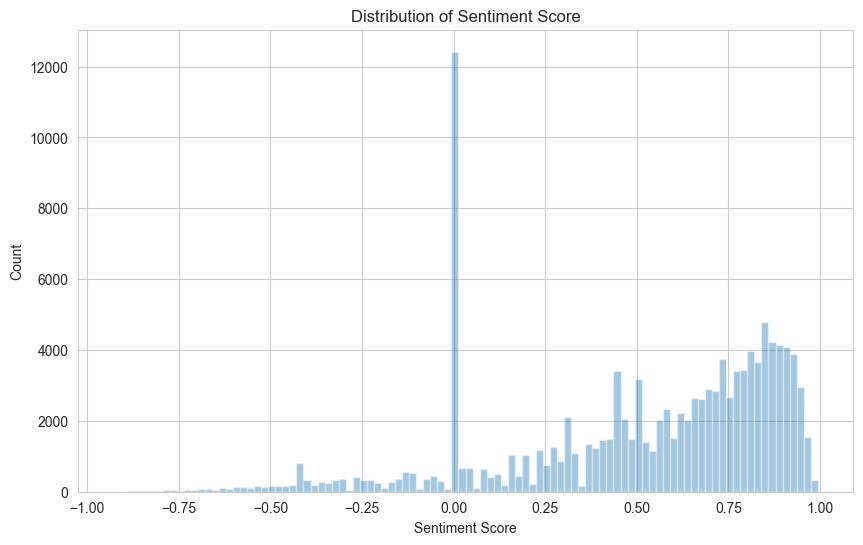

In [ ]:

df['sentiment'] = sentiment.compound.apply(lambda x: "positive" if x >= 0.15 else ("negative" if x <= -0.05 else "neutral"))
df['vintage'] = df.apply(extract_vintage, axis=1)
sentiment_df = df.join(sentiment.compound.rename('sentiment_score'))

# plot the distribution of compound score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.distplot(sentiment_df.sentiment_score, bins=100, kde=False)
plt.title("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()


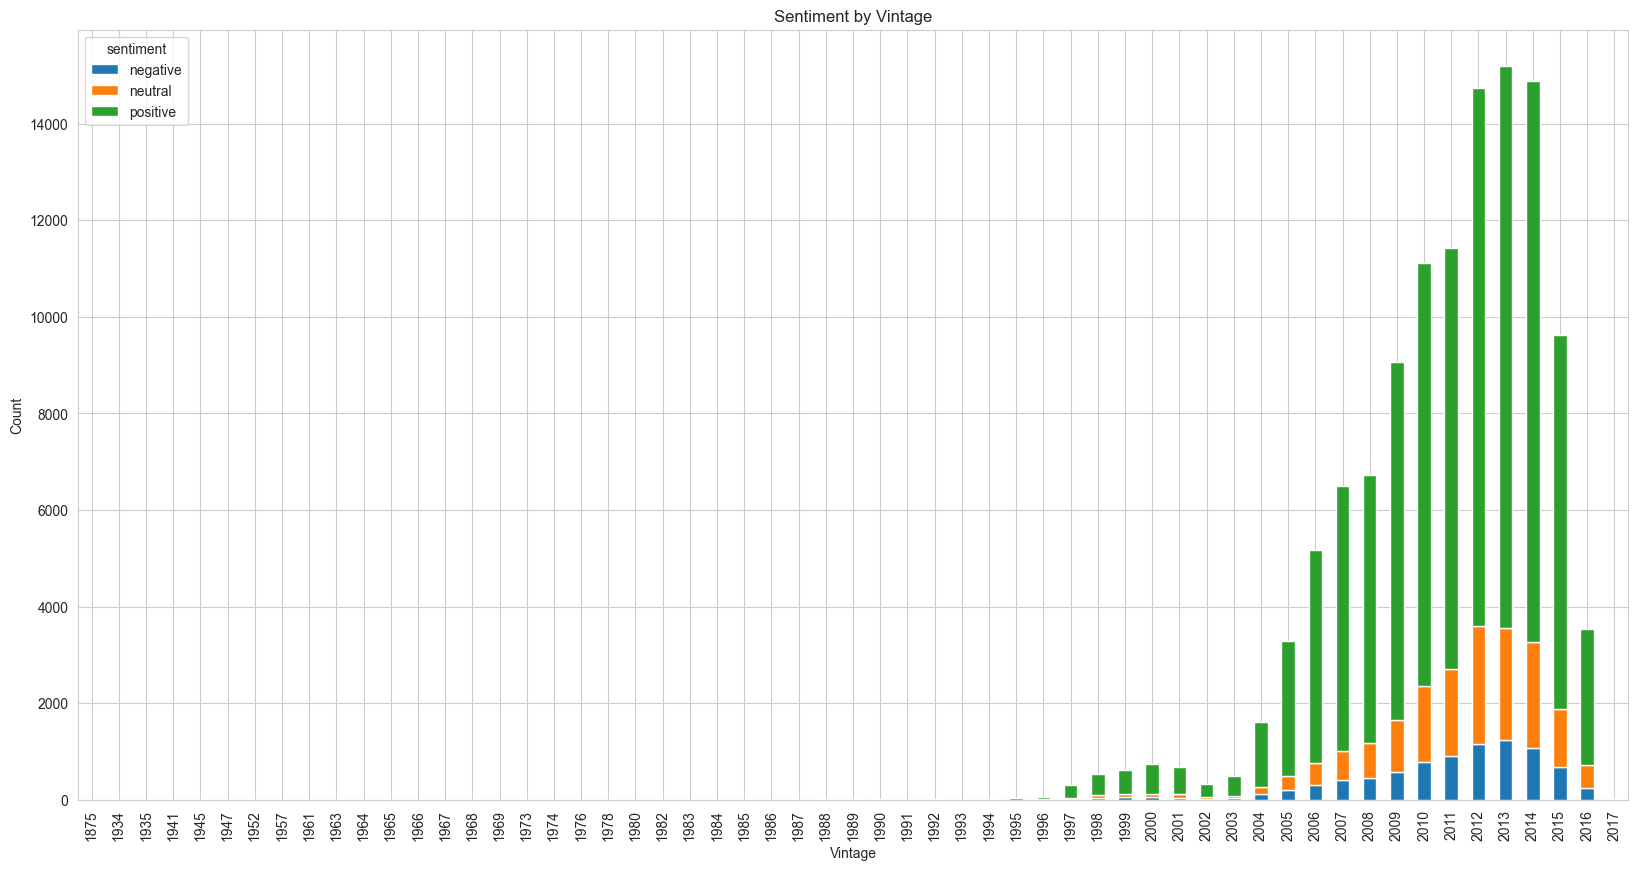

In [ ]:
# plot stacked bar chart of sentiment by vintage
sentiment_by_vintage = sentiment_df.groupby(['vintage', 'sentiment']).size().unstack()
sentiment_by_vintage.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title("Sentiment by Vintage")
plt.xlabel("Vintage")
plt.ylabel("Count")
plt.show()

In [ ]:
sentiment_df

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery,sentiment,vintage,sentiment_score
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,not specified,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,positive,2011,0.6486
2,2,US,"Tart and snappy, the flavors of lime flesh and...",not specified,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,negative,2013,-0.1280
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,positive,2013,0.3400
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,positive,2012,0.8176
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,positive,2011,0.1655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,not specified,Anna Lee C. Iijima,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),positive,2013,0.7331
129967,129967,US,Citation is given as much as a decade of bottl...,not specified,90,75.0,Oregon,Oregon,Paul Gregutt,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,positive,2004,0.5267
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Roger Voss,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,positive,2013,0.1548
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",not specified,90,32.0,Alsace,Alsace,Roger Voss,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,positive,2012,0.5267


In [ ]:
sentiment_df.groupby('variety').sentiment_score.mean().sort_values().iloc[-10:]

variety
Bombino Nero                0.9081
Tinta Madeira               0.9097
Gelber Traminer             0.9153
Früburgunder                0.9186
Torbato                     0.9186
Garnacha-Cariñena           0.9259
Roussanne-Grenache Blanc    0.9260
Grignolino                  0.9432
Blauburgunder               0.9493
Moscato di Noto             0.9786
Name: sentiment_score, dtype: float64

In [ ]:
sentiment_df.groupby('taster_name').sentiment_score.mean().sort_values()

taster_name
Fiona Adams           0.319196
Michael Schachner     0.328185
Carrie Dykes          0.358342
Alexander Peartree    0.358631
Sean P. Sullivan      0.378992
Matt Kettmann         0.383448
Kerin O’Keefe         0.387522
Jeff Jenssen          0.410948
Joe Czerwinski        0.449845
Virginie Boone        0.466649
Mike DeSimone         0.476825
Paul Gregutt          0.507236
Anna Lee C. Iijima    0.579201
annoymous             0.594112
Lauren Buzzeo         0.603456
Roger Voss            0.618233
Christina Pickard     0.633017
Susan Kostrzewa       0.684052
Jim Gordon            0.686908
Anne Krebiehl MW      0.704005
Name: sentiment_score, dtype: float64

In [ ]:
sentiment_df.groupby('vintage').sentiment_score.mean()

vintage
1875   -0.421500
1934    0.873900
1935    0.906200
1941    0.868200
1945    0.612400
1947    0.599400
1952    0.903600
1957    0.815100
1961    0.958300
1963    0.718833
1964    0.867150
1965    0.943500
1966    0.954500
1967    0.840200
1968    0.910000
1969    0.932500
1973    0.827100
1974    0.969800
1976    0.542300
1978    0.182900
1980    0.877050
1982    0.910900
1983    0.561550
1984    0.931300
1985    0.837925
1986    0.678250
1987    0.905200
1988    0.365680
1989    0.671033
1990    0.510840
1991    0.512050
1992    0.743793
1993    0.389333
1994    0.752583
1995    0.728920
1996    0.596745
1997    0.600287
1998    0.552049
1999    0.534418
2000    0.559054
2001    0.563953
2002    0.552642
2003    0.573895
2004    0.574753
2005    0.585645
2006    0.582711
2007    0.573706
2008    0.552431
2009    0.537795
2010    0.499520
2011    0.472669
2012    0.462603
2013    0.465830
2014    0.490061
2015    0.514270
2016    0.504428
2017    0.263164
Name: sentiment_score, 